## ENSO


## Description from the dataset
Your task is to explore and analyze the ENSO dataset and create a predictive model for
ENSO anomaly values. The project is divided into two parts. In the first part, you will focus
on Exploratory Data Analysis (EDA) to gain a deep understanding of the dataset, including
its variables and their relationships. In the second part, you will apply machine learning
techniques to predict ENSO anomalies. We encourage you to explore additional data
sources if you find them valuable for your analysis. You can find valuable information for the
project on the following page: ENSO Information.

## Getting the dataset and creating the dataset
Based on the ENSO webpage, most of the data is stored in a api, so for that we need to request the data using an API

In [1]:
#Libraries used to acquiring data
import requests

#Libraries used for Exploratory Data Analysis
import numpy as np
import pandas as pd

#Libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Libraries for first Machine Learning Model
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#Libraries for second Machine Learning Model
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv1D, MaxPooling1D, Flatten, SimpleRNN, LSTM, TimeDistributed
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.linear_model import Ridge

# Just to remove some warnings
import warnings
warnings.filterwarnings("ignore")
     

2023-10-15 20:39:41.939138: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


I'm going to be working with the Pacific Sea Surface Temperatures since I found the data shows the date, regions and temperatures which are going to be useful to show the ENSO anomaly values

In [2]:
#Getting the url from the webpage 
# Equatorial Pacific Sea Surface Temperatures (SST) is the dataset used in this case
url = 'https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices'
# using the request format to get a response
response = requests.get(url)

In [3]:
#checking the status of the request, if the result is "200" the api was sucessfully implemented
response.status_code

200

In [4]:
#Once I know that the status code was "200" I have to dig into the dataset
if response.status_code == 200:
    with open("nino4.long.anom.data", 'wb') as f:
        f.write(response.content)
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")

File downloaded successfully.


In [5]:
# the file path of our dataset
file_path = "nino4.long.anom.data"
#now we are openning the file
with open(file_path, 'r') as file:
    data = file.read()

# I print the data to visualize it 

## Creating the dataset
For this, I know that the dataset is in form "string", so I have to split each line of the string, then separating and splitting the columns from the values

In [6]:
#getting the values from the first row
lines = data.split('\n')
#now separating the first row from the rest of the dataframe because it is the name of the columns
columns = lines[0].split()
#getting all the values except for the first row and splitting them 
values = [line.split() for line in lines[1:]]


I'm creating a cute dataset so I can start doing the data analysis

In [7]:
df = pd.DataFrame(values, columns = columns)
df

,YR,MON,NINO1+2,ANOM,NINO3,ANOM,NINO4,ANOM,NINO3.4,ANOM
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49
...,...,...,...,...,...,...,...,...,...,...
497,2023,6,25.81,2.63,27.85,1.21,29.48,0.64,28.59,0.88
498,2023,7,25.05,3.21,27.47,1.59,29.50,0.71,28.37,1.07
499,2023,8,24.16,3.30,27.17,1.96,29.65,0.95,28.20,1.30
500,2023,9,23.40,2.82,27.08,2.07,29.77,1.10,28.29,1.53


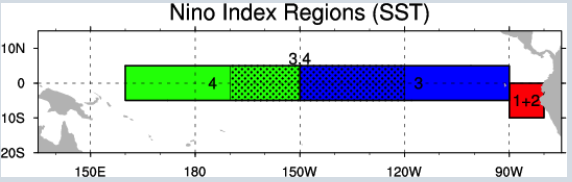

After a little of digging on the internet, I was wondering what does the Nino 4, 1+2, 3 and 3.4 mean. I assume that these columns would all mean the same category but in different stations but I was wrong. Based on the information provided in "https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni" they all mean the regions in which they measure the data, being the region 3.4 "the most commonly used indices to define el Niño events. 

Also, based on the webpage provided "https://www.ncei.noaa.gov/access/monitoring/enso/sst" ANOM would mean anomalies. Anomalies in the Niño 3.4 region that is above (below) the threshold of +0.5°C (-0.5°C). This standard of measure is known as the Oceanic Niño Index (ONI).

## Exploratory Data Analysis

## Cleaning Missing Values 

In [8]:
#I want to know how many not a number values (nan)my dataset contains and I want to know if there are rows or columns with 
#missing values

#Missing values per column
nan_columns = df.isna().sum(axis = 0)
print(f"missing values per column:{nan_columns}")
#Missing values per row
nan_rows = df.isna().sum(axis = 1)
print(f"missing values per row:{nan_rows}")

missing values per column:YR         1
MON        1
NINO1+2    1
ANOM       1
NINO3      1
ANOM       1
NINO4      1
ANOM       1
NINO3.4    1
ANOM       1
dtype: int64
missing values per row:0       0
1       0
2       0
3       0
4       0
       ..
497     0
498     0
499     0
500     0
501    10
Length: 502, dtype: int64


I have concluded that there is only one row (501) with a missing value so I would drop this since it is statistically insignificant to alter our results in our data (1/502)*100 = 0.199 or less than 1%. 

In [9]:
df = df.dropna()
df

,YR,MON,NINO1+2,ANOM,NINO3,ANOM,NINO4,ANOM,NINO3.4,ANOM
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49
...,...,...,...,...,...,...,...,...,...,...
496,2023,5,26.63,2.02,28.11,0.90,29.12,0.33,28.35,0.47
497,2023,6,25.81,2.63,27.85,1.21,29.48,0.64,28.59,0.88
498,2023,7,25.05,3.21,27.47,1.59,29.50,0.71,28.37,1.07
499,2023,8,24.16,3.30,27.17,1.96,29.65,0.95,28.20,1.30


### Casting types of data

We are working with numbers but the data has been downloaded as object, so I would change that for a numerical values. Also I have to point out that there are columns such as "YR" and "MON" that correspond to a datetime.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   YR       501 non-null    object
 1   MON      501 non-null    object
 2   NINO1+2  501 non-null    object
 3   ANOM     501 non-null    object
 4   NINO3    501 non-null    object
 5   ANOM     501 non-null    object
 6   NINO4    501 non-null    object
 7   ANOM     501 non-null    object
 8   NINO3.4  501 non-null    object
 9   ANOM     501 non-null    object
dtypes: object(10)
memory usage: 43.1+ KB


In [11]:
df.columns 

Index(['YR', 'MON', 'NINO1+2', 'ANOM', 'NINO3', 'ANOM', 'NINO4', 'ANOM',
       'NINO3.4', 'ANOM'],
      dtype='object')

Based on previous experience, instead of joining two columns, I'm going to make two new columns. One with the dates combined and applying a pd.to_datetime() and another one counting the months. These would later help us with our machine learning algorithms

In [12]:
df['date'] = df['YR'] + '-' + df['MON']
df['date'] = pd.to_datetime(df['date'], errors='coerce', format='%Y-%m')
#df['date'] = df['date'].dt.to_period('M')
df['Months'] = (df['date'] - df['date'].min()).dt.days // 30
df

,YR,MON,NINO1+2,ANOM,NINO3,ANOM,NINO4,ANOM,NINO3.4,ANOM,date,Months
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,1982-01-01,0
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,1982-02-01,1
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,1982-03-01,1
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,1982-04-01,3
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,1982-05-01,4
...,...,...,...,...,...,...,...,...,...,...,...,...
496,2023,5,26.63,2.02,28.11,0.90,29.12,0.33,28.35,0.47,2023-05-01,503
497,2023,6,25.81,2.63,27.85,1.21,29.48,0.64,28.59,0.88,2023-06-01,504
498,2023,7,25.05,3.21,27.47,1.59,29.50,0.71,28.37,1.07,2023-07-01,505
499,2023,8,24.16,3.30,27.17,1.96,29.65,0.95,28.20,1.30,2023-08-01,506


Since, the data is numerical, we need to change these values from object into numerical

In [13]:
dictionary = {'YR': "int", "MON":"int", 
               'NINO1+2':"float", 'ANOM':"float", 'NINO3':"float", 'ANOM':"float", 'NINO4':"float", 'ANOM':"float",
       'NINO3.4':"float", 'ANOM':"float"
              }

#Changing the values to a float, they can't be integers because the data contains decimal points
df = df.astype(dictionary)
#df[['YR', "MON"]] = df[['YR', "MON"]].astype(int)
# As we can see the columns "YR" is the year recorded, I could change this to numerical but in this case I would try to
#use a datetime, later if I see this is getting an obstacle in my analysis I would change it to numerical (int)
## *** df['YR']= df['YR'].astype('datetime64[ns]')*** ##

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   YR       501 non-null    int64         
 1   MON      501 non-null    int64         
 2   NINO1+2  501 non-null    float64       
 3   ANOM     501 non-null    float64       
 4   NINO3    501 non-null    float64       
 5   ANOM     501 non-null    float64       
 6   NINO4    501 non-null    float64       
 7   ANOM     501 non-null    float64       
 8   NINO3.4  501 non-null    float64       
 9   ANOM     501 non-null    float64       
 10  date     501 non-null    datetime64[ns]
 11  Months   501 non-null    int64         
dtypes: datetime64[ns](1), float64(8), int64(3)
memory usage: 50.9 KB


In [15]:
#shape of the dataset
df.shape

(501, 12)

In [16]:
# name of the columns
df.columns 
# Since several columns are called, "ANOM" we need to change this to the column they are assigned to and also change
#the column "NINO1+2"
d = {"ANOM": ["ANOM1_2", "ANOM3", "ANOM4", "ANOM3.4"]}
df = df.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
df = df.rename(columns = {"NINO1+2":'NINO1_2'})
df['date']


0     1982-01-01
1     1982-02-01
2     1982-03-01
3     1982-04-01
4     1982-05-01
         ...    
496   2023-05-01
497   2023-06-01
498   2023-07-01
499   2023-08-01
500   2023-09-01
Name: date, Length: 501, dtype: datetime64[ns]

## Descriptive Statistics

Now, after all that casting, cleaning, and modifications, how does our data look like?,so for this I want to visualize it using a boxplot. This would show me any outlier and atypical data that our dataset has.

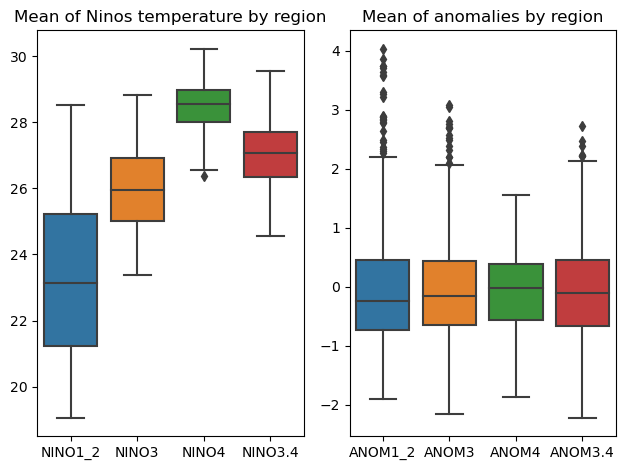

In [17]:
plt.subplot(1, 2, 1)
plt.title('Mean of Ninos temperature by region')
ax1 = sns.boxplot(data=df[['NINO1_2', 'NINO3', 'NINO4', 'NINO3.4']])

# Displaying values on the first boxplot
for i in range(len(df[['NINO1_2', 'NINO3', 'NINO4', 'NINO3.4']].columns)):
    for j in ax1.artists[i*6:(i+1)*6]:
        x = j.get_x() + j.get_width() / 2
        y = j.get_y() + j.get_height() + 0.3
        ax1.text(x, y, f'{df[df.columns[i]].values}', ha="center")

# Second plot
plt.subplot(1, 2, 2)
plt.title('Mean of anomalies by region')
ax2 = sns.boxplot(data=df[['ANOM1_2', 'ANOM3', 'ANOM4', 'ANOM3.4']])

# Displaying values on the second boxplot
for i in range(len(df[['ANOM1_2', 'ANOM3', 'ANOM4', 'ANOM3.4']].columns)):
    for j in ax2.artists[i*6:(i+1)*6]:
        x = j.get_x() + j.get_width() / 2
        y = j.get_y() + j.get_height() + 0.3
        ax2.text(x, y, f'{df[df.columns[i]].values}', ha="center")

plt.tight_layout()
plt.show()

In [18]:
print(f'Minimum Value for ANOM3.4: {df["ANOM3.4"].min()}')
print(f'10- quantile for ANOM3.4: {df["ANOM3.4"].quantile(0.1)}')
print(f'25- quantile for ANOM3.4: {df["ANOM3.4"].quantile(0.25)}')
print(f'50- Median for ANOM3.4: {df["ANOM3.4"].median()}')
print(f'75- quantile for ANOM3.4: {df["ANOM3.4"].quantile(0.75)}')
print(f'90- quantile for ANOM3.4: {df["ANOM3.4"].quantile(0.9)}')
print(f'Maximum value for ANOM3.4: {df["ANOM3.4"].max()}')



Minimum Value for ANOM3.4: -2.22
10- quantile for ANOM3.4: -1.05
25- quantile for ANOM3.4: -0.67
50- Median for ANOM3.4: -0.11
75- quantile for ANOM3.4: 0.45
90- quantile for ANOM3.4: 0.94
Maximum value for ANOM3.4: 2.72


In [19]:
print(f'Minimum Value for "NINO1_2: {df["NINO1_2"].min()}')
print(f'Median Nino1_2: {df["NINO1_2"].median()}')
print(f'25- quantile for "NINO1_2": {df["NINO1_2"].quantile(0.25)}')
print(f'75- quantile for "NINO1_2": {df["NINO1_2"].quantile(0.75)}')
print(f'Maximum value for "NINO1_2": {df["NINO1_2"].max()}')



Minimum Value for "NINO1_2: 19.06
Median Nino1_2: 23.15
25- quantile for "NINO1_2": 21.22
75- quantile for "NINO1_2": 25.23
Maximum value for "NINO1_2": 28.51


In [20]:
#Medians for Temperatures in regions 
print(f'Median for Nino4: {df["NINO4"].median()}')
print(f'Median for Nino3.4: {df["NINO3.4"].median()}')


Median for Nino4: 28.56
Median for Nino3.4: 27.07


In [21]:
#median for Anom1_2 region
print(f'Median for ANOM1_2: {df["ANOM1_2"].median()}')

Median for ANOM1_2: -0.24


Acording to the charts above: 
* Region Nino 1-2 shows a bigger spread of data with a Maximum value of 28.51 degrees and a Minimum of 19.06 degrees which is a big spread. Based on information from "https://climatedataguide.ucar.edu/climate-data/", this index tends to have the largest variance of the Niño SST indices so it makes sense that this boxplot shows this varience.
* Anomalities at the region 1-2 also show a lot of outliers. I could not found information into why this happens, but it correlates with the temperatures seen in the nino 1-2 
* Region Nino 3.4 also has a median temperature of 27.07. So it shows that temperatures rises the further away you are from the coast. 


In [22]:
df.groupby('YR').size()
described = df.groupby('YR').agg(['mean', 'median', 'std'])
described = described[['NINO1_2', 'NINO3', 'NINO4', 'NINO3.4','ANOM1_2', 'ANOM3', 'ANOM4', 'ANOM3.4']]
described.tail()

NINO1_2                        NINO3                        NINO4  \
           mean  median       std       mean  median       std       mean   
YR                                                                          
2019  23.278333  23.130  2.702574  26.401667  26.170  1.203275  29.287500   
2020  22.857500  22.145  2.636599  25.682500  25.670  1.331801  28.578333   
2021  22.779167  22.600  1.992182  25.524167  25.415  0.993529  28.125833   
2022  22.166667  22.155  2.247400  25.220833  25.005  0.947115  27.820833   
2023  25.824444  25.810  1.735058  27.182222  27.470  0.944335  28.846667   

                         NINO3.4  ...   ANOM1_2     ANOM3                   \
     median       std       mean  ...       std      mean median       std   
YR                                ...                                        
2019  29.30  0.198408  27.626667  ...  0.574084  0.375833  0.395  0.342994   
2020  28.83  0.521167  26.811667  ...  0.506828 -0.341667 -0.425  0.480773   
2021  28.18  0.560900  26.540833  ...  0.543111 -0.500000 -0.490  0.333412   
2022  27.78  0.191523  26.237500  ...  0.453057 -0.803333 -0.845  0.225362   
2023  29.12  0.872038  27.687778  ...  1.189475  0.877778  0.900  0.907218   

         ANOM4                    ANOM3.4                   
          mean median       std      mean median       std  
YR                                                          
2019  0.734167  0.730  0.111229  0.533333   0.56  0.269016  
2020  0.024167  0.045  0.640205 -0.282500  -0.24  0.632558  
2021 -0.425833 -0.415  0.350285 -0.555000  -0.56  0.331292  
2022 -0.731667 -0.795  0.278203 -0.855000  -0.87  0.128947  
2023  0.307778  0.330  0.614670  0.477778   0.47  0.776414  

[5 rows x 24 columns]

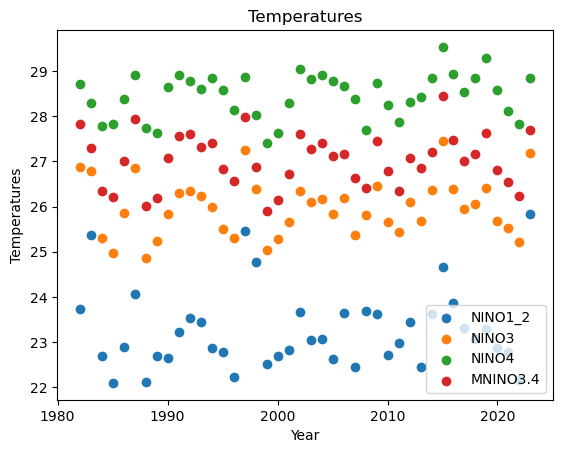

In [23]:
plt.scatter(described.index, described[('NINO1_2', 'mean')], label='NINO1_2')
plt.scatter(described.index, described[('NINO3', 'mean')], label='NINO3')
plt.scatter(described.index, described[('NINO4', 'mean')], label='NINO4')
plt.scatter(described.index, described[('NINO3.4', 'mean')], label='MNINO3.4')
plt.xlabel('Year')
plt.ylabel('Temperatures')
plt.title('Temperatures')
plt.legend()
plt.show()

Another scatter plot of the mean of temperatures for each region. Just like we can see in the boxplot but in a time frame

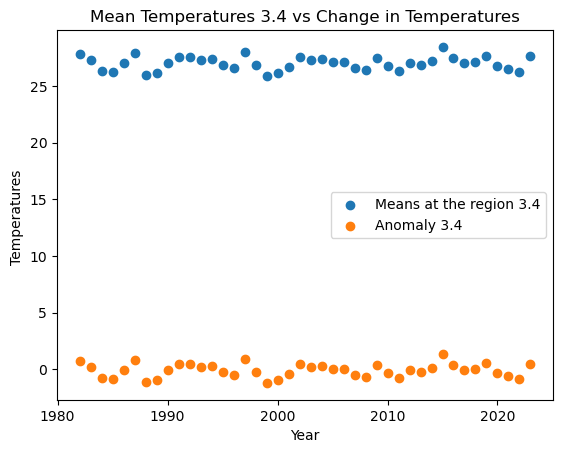

In [24]:
plt.scatter(described.index, described[('NINO3.4', 'mean')], label='Means at the region 3.4')
plt.scatter(described.index, described[('ANOM3.4', 'mean')], label='Anomaly 3.4')
plt.xlabel('Year')
plt.ylabel('Temperatures ')
plt.title('Mean Temperatures 3.4 vs Change in Temperatures')
plt.legend()
plt.show()

* This charts shows the behaviour between anomalities and temperatures 
* There is an oscillation on temperatures as well. 

# Correlation

In [25]:
df.corr()

,YR,MON,NINO1_2,ANOM1_2,NINO3,ANOM3,NINO4,ANOM4,NINO3.4,ANOM3.4,Months
YR,1.000000,-0.013387,0.015505,0.019321,0.038938,0.045600,0.158981,0.171198,0.031848,0.031313,0.999714
MON,-0.013387,1.000000,-0.708109,0.014105,-0.478000,0.003268,0.200964,-0.000441,-0.123704,0.004400,0.010432
NINO1_2,0.015505,-0.708109,1.000000,0.436616,0.783083,0.358189,-0.028689,0.196426,0.395587,0.279169,-0.001538
ANOM1_2,0.019321,0.014105,0.436616,1.000000,0.551033,0.810501,0.412312,0.436090,0.554010,0.635123,0.019324
NINO3,0.038938,-0.478000,0.783083,0.551033,1.000000,0.689316,0.436385,0.512504,0.849452,0.646957,0.027144
ANOM3,0.045600,0.003268,0.358189,0.810501,0.689316,1.000000,0.683803,0.731187,0.821176,0.938430,0.045173
NINO4,0.158981,0.200964,-0.028689,0.412312,0.436385,0.683803,1.000000,0.935311,0.802807,0.823437,0.163306
ANOM4,0.171198,-0.000441,0.196426,0.436090,0.512504,0.731187,0.935311,1.000000,0.778455,0.881354,0.170709
NINO3.4,0.031848,-0.123704,0.395587,0.554010,0.849452,0.821176,0.802807,0.778455,1.000000,0.875451,0.028376
ANOM3.4,0.031313,0.004400,0.279169,0.635123,0.646957,0.938430,0.823437,0.881354,0.875451,1.000000,0.030874


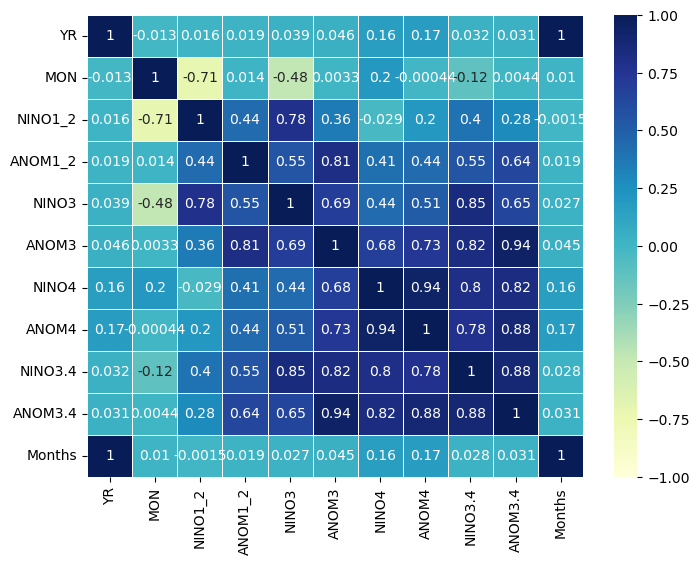

In [26]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="YlGnBu", linewidths=.5)

I made a correlation because in my internal process I thought the data was going to fit in a linear regression, but then I noticed that this case is not a simple linear regression but a time series. I left the notebook unchanged so I can show my internal process as data scientist instead of showing a "all correct-solution notebook"

## Machine Learning  (Time Series using LinearRegression())

This dataset contains labels, hence we can only applied supervised algorithms. If we tried to make a prediction based on the previous dates, we can use a time series algorithm to show a predict anomaly

In [44]:
# Convert date to ordinal
X = df[['Months']]
y = df['ANOM3.4']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for the model
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)



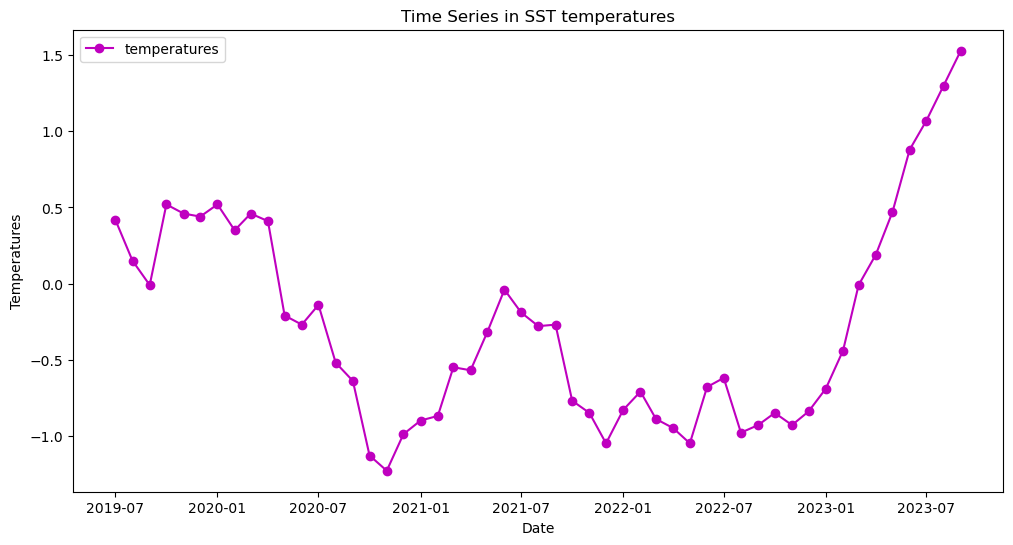

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'][450:], df['ANOM3.4'][450:], label='temperatures', marker='o', linestyle='-', color='m')
plt.xlabel('Date')
plt.ylabel('Temperatures')
plt.title('Time Series in SST temperatures')
plt.legend()
plt.show()

In [46]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
     

LinearRegression()

In [47]:
# Realizar predicciones en el conjunto de prueba
y_pred = regression_model.predict(X_test)   


In [48]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

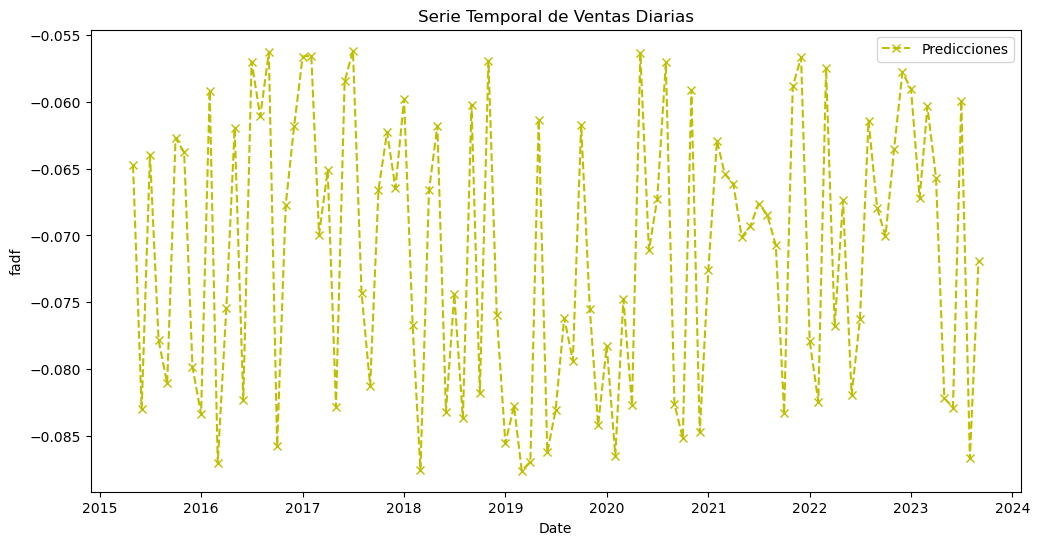

Mean-Squared Error training: 0.9131762307759517
R^2 in training: 0.0017522997300092324


In [53]:
plt.figure(figsize=(12, 6))
#plt.plot(df['date'][450:], df['ANOM3.4'][450:], label='Ventas Diarias', marker='o', linestyle='-')
plt.plot(df['date'][len(X_train):], y_pred, label='Predicciones', marker='x', linestyle='--', color='y')
plt.xlabel('Date')
plt.ylabel('fadf')
plt.title('Serie Temporal de Ventas Diarias')
plt.legend()
plt.show()

# print the results
print("Mean-Squared Error training:", mse)
print("R^2 in training:", r2)
     

* In this case my Mean Squared Error (MSE) of 0.91 indicates that, on average, the square of the differences between the predicted values and the actual values is 0.91. Which is higher of what I expected.

* Since the mean-square error is too high and R-square shows a bad performance in the predicted value, I decided that this algorithm did not predict correctly a set forecasted values. So I went back to my college notes and I did a similar procedure using the same tool the LinearRegression() with a more changed dataset. Next I continue to applied the same approach but now looking at my college notes and a more well refined values.

* A higher R-squared value is generally considered better as it indicates that the model is successful at explaining the variability of the response data around its mean.

## Machine Learning  (Time Series using my college's notebook)

In [33]:
# Use only the columns of importance. Since We only want to predict the anomalies, I would only select datetimes and
# -- temperatures of the anom3.4 column 
new_df = df[['date', 'ANOM3.4']]
new_df 

,date,ANOM3.4
0,1982-01-01,0.08
1,1982-02-01,-0.20
2,1982-03-01,-0.14
3,1982-04-01,0.02
4,1982-05-01,0.49
...,...,...
496,2023-05-01,0.47
497,2023-06-01,0.88
498,2023-07-01,1.07
499,2023-08-01,1.30


Now, with this approach I want to make a formula such that it takes the dates and tranpose them so I can use the values of dates as columns and anom3.4 the values of my columns. Like a type of "cross-validation" where we take one element and applying the training to the rest.

In [55]:
def transformarSerieaDataset(serie, elementspormuestra):
    dataset = None
    salidasDataset = None
    for counter in range(len(serie) - elementspormuestra - 1):
        muestra = np.array([serie[counter:counter + elementspormuestra]])
        salida = np.array([serie[counter + elementspormuestra]])
        if dataset is None:
            dataset = muestra
        else:
            dataset = np.append(dataset, muestra, axis=0)
        if salidasDataset is None:
            salidasDataset = salida
        else:
            salidasDataset = np.append(salidasDataset, salida)
    return dataset, salidasDataset

In [56]:
serie = new_df['ANOM3.4'].to_numpy()
# What I'm telling my code is that based on 10 months, to predict the weather for the next month. I can change that 
# with the elementspormuestra but for now I'll just set it to 10
X, Y = transformarSerieaDataset(serie, elementspormuestra = 10)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=5)


In [58]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [63]:
y_train_predict = lin_model.predict(X_train)
MSE = mean_squared_error(y_train, y_train_predict)
print("training: MSE= ", str(MSE))

y_test_predict = lin_model.predict(X_test)
MSE = (mean_squared_error(y_test, y_test_predict))
print('test: MSE='+str(MSE))

r2 = r2_score(y_test, y_test_predict)
print("R^2 in training:", r2)
     

training: MSE=  0.08639573577422031
test: MSE=0.08928346007840145
R^2 in training: 0.8585768086987179


* In this case my Mean Squared Error (MSE) of 0.08 This suggests that the model is better at predicting the outcome. 0.08 is a relatively small error, which suggests that the model's predictions are, on average, quite close to the actual values.

* An R-squared value of 0.85 indicates that 85% of the variance in the dependent variable can be explained by the independent variables in the model. In simpler terms, it suggests that 85% of the variability in the response variable is accounted for by the model. 

* So in this case a value of 0.85 suggests that the model provides a good fit to the data and can explain a significant portion of the variance in the dependent variable. Combined with the low Mean Squared Error, these metrics indicate that my model is performing well and is relatively accurate in making prediction

In [60]:
df_predictions = pd.DataFrame({'Real value':y_test, 'predictions':y_test_predict, 'difference': y_test - y_test_predict})
df_predictions = df_predictions.reset_index(drop= True)
df_predictions.head(10)

,Real value,predictions,difference
0,0.66,0.573128,0.086872
1,0.42,0.393271,0.026729
2,-1.48,-1.617755,0.137755
3,-0.20,-0.518266,0.318266
4,-0.55,-0.592793,0.042793
5,-0.99,-1.030393,0.040393
6,-0.34,-0.971297,0.631297
7,0.75,0.600281,0.149719
8,-0.60,-0.745723,0.145723
9,-0.56,-0.633922,0.073922


In this case, "Real Value" would mean the ENSO anomaly values that I have on my dataset. The column "predictions" is the outcome that our algorithm gave based on the previous datapoints. Difference shows how much my algorithm differs from the actual value which is minimal.

## Using Ridge function to "forecast" the values of the next anomalies at the Region 3.4

In [61]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create and fit the Ridge regression model
ridge = Ridge(alpha=1.0)  # You can set the alpha parameter as per your requirements
ridge.fit(X_train, y_train)

# Make predictions
y_pred = ridge.predict(X_test)

# Assess the model
ridge_score = ridge.score(X_test, y_test)
print("Ridge regression score: {:.2f}".format(ridge_score))

Ridge regression score: 0.89


What we want is to find the best values that predict the result: Linear regression 

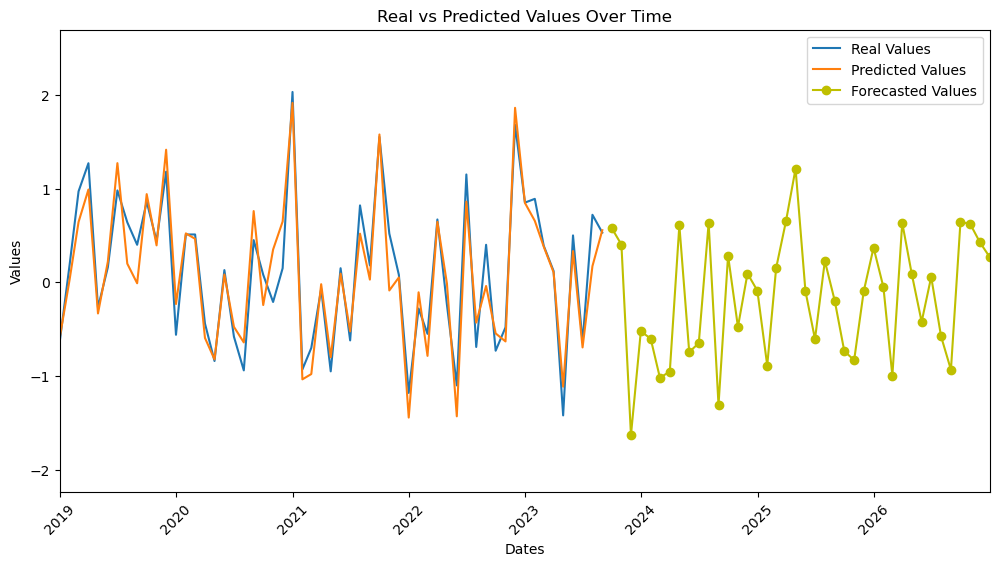

In [62]:
num_forecast_points = len(y_pred)  # Assuming y_pred contains the predicted values
last_date = df['date'].iloc[-1]  # Assuming df is your DataFrame
future_dates = pd.date_range(last_date, periods=num_forecast_points, freq='M')


plt.figure(figsize=(12, 6))
plt.plot(new_df['date'][-len(y_test):], y_test, label='Real Values')
plt.plot(new_df['date'][-len(y_test):], y_test_predict, label='Predicted Values')
plt.plot(future_dates, y_pred, label='Forecasted Values', marker='o', color = "y")
plt.xlabel('Dates')
plt.ylabel('Values')
plt.title('Real vs Predicted Values Over Time')
plt.legend()
plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2026-12-31'))
plt.xticks(rotation=45)
plt.show()



In [42]:
next_temp = pd.DataFrame(y_pred, future_dates)
next_temp.head(10)

,0
2023-09-30,0.581734
2023-10-31,0.402445
2023-11-30,-1.630451
2023-12-31,-0.521753
2024-01-31,-0.601910
2024-02-29,-1.019086
2024-03-31,-0.951795
2024-04-30,0.608068
2024-05-31,-0.744763
2024-06-30,-0.648284


Just showing on a small dataframe what the next temperatures are.

# Conclusions 

* Model Performance: After cleaning the data in the second set and using my college notes I had a better mean squared error (MSE) of 0.08, the model's predictions are relatively close to the actual values on average, suggesting a good predictive performance.

* Variability: The R-squared value of 0.85 indicates that approximately 85% of the variability in the dependent variable is accounted for by the independent variables in the model, demonstrating a strong relationship between the variables. So, I would love to use this one to predict the temperatures in the region 3-4 but due to time constraints I would just leave it like that.

* Model Fit: The combination of a low MSE and a high R-squared value suggests that the model is well-fitted to the data and is successful in explaining the relationship between the variables under consideration.

* Reliability: The high R-squared value implies that the model is reliable for explaining the changes in the dependent variable based on the independent variables.

* Data Quality: The dataset appears to be relatively consistent and well-structured, allowing for a reliable model fit and accurate predictions. It is well-recorded data and I would just like to see how my prediction would match with the real data that is going to be recorded. Also would love to have a separated data or information into why the temperatures are more varied in the region called Nino1-2